# Computer Vision, Assignment 3: Epipolar Geometry

In this assignment, you will study epipolar geometry. 
You will use the fundamental matrix and the essential matrix for simultaneously reconstructing the 3D structure and the camera motion from two images.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are ``mandatory'' in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).

In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io

from supplied import pflat, plot_camera, rital

# The Fundamental Matrix

#### *Theoretical exercises 1-4* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/kronan1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/kronan2.JPG" width="250px">
    <figcaption>Figure1. kronan1.jpg and kronan2.jpg</figcaption>
</figure>

In this exercise you will compute the fundamental matrix for the two images above, showing a part of the fort Kronan in Gothenburg. The calibration matrix $K$ is assumed to be unknown. The file `compEx1data.mat` contains a cell `x` with matched points for the two images.

### Task 1.1
Compute normalization matrices $N_1$ and $N_2$. These matrices should subtract the mean and re-scale using the standard deviation, as in assignment 2.
Normalize the image points of the two images with $N_1$ and $N_2$, respectively.

In [2]:
# Load the data
data = scipy.io.loadmat('data/compEx1data.mat')
x = data['x']
x1 = x[0, 0]  # 3xN homogeneous coordinates
x2 = x[1, 0]  # 3xN homogeneous coordinates

# Compute N1 (subtract mean, scale by std)
mean1 = np.mean(x1[:2, :], axis=1, keepdims=True)
std1 = np.std(x1[:2, :])
N1 = np.array([[1/std1, 0, -mean1[0, 0]/std1],
               [0, 1/std1, -mean1[1, 0]/std1],
               [0, 0, 1]])

# Compute N2 (subtract mean, scale by std)
mean2 = np.mean(x2[:2, :], axis=1, keepdims=True)
std2 = np.std(x2[:2, :])
N2 = np.array([[1/std2, 0, -mean2[0, 0]/std2],
               [0, 1/std2, -mean2[1, 0]/std2],
               [0, 0, 1]])

# Normalize the image points
x1_norm = N1 @ x1
x2_norm = N2 @ x2

print("N1:")
print(N1)
print("\nN2:")
print(N2)
print(f"\nNumber of point correspondences: {x1.shape[1]}")



N1:
[[ 0.0025638   0.         -2.18245631]
 [ 0.          0.0025638  -1.7117855 ]
 [ 0.          0.          1.        ]]

N2:
[[ 0.00245951  0.         -1.87034146]
 [ 0.          0.00245951 -1.63354683]
 [ 0.          0.          1.        ]]

Number of point correspondences: 2008


### Task 1.2
Set up the matrix $M$ in the eight point algorithm (8 is the minimum number of points, you should use all the points here), and solve the homogeneous least squares system using SVD. 
Check that the minimum singular value and $||Mv||$ are both small. Construct the $3 \times 3$ matrix $\tilde F$ from the solution $v$. This matrix should approximately satisfy $\tilde x_2^T \tilde F \tilde x_1 = 0$, where $\tilde x_j$ are normalized image points. Write the code as a function which would be useful later. 

In [3]:
def estimate_F_DLT(x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    '''
    # Number of point correspondences
    n = x1s.shape[1]
    
    # Build the matrix M for the DLT algorithm
    # Each correspondence gives one equation: x2' * F * x1 = 0
    M = np.zeros((n, 9))
    
    for i in range(n):
        x1_i = x1s[:, i]
        x2_i = x2s[:, i]
        # Kronecker product: vec(F) form
        M[i, :] = np.kron(x2_i, x1_i)
    
    # Solve using SVD
    U, S, Vt = np.linalg.svd(M)
    
    # The solution is the last row of Vt (corresponding to smallest singular value)
    v = Vt[-1, :]
    
    # Check that minimum singular value is small
    print(f"Minimum singular value: {S[-1]:.6e}")
    print(f"||Mv||: {np.linalg.norm(M @ v):.6e}")
    
    # Reshape v into 3x3 matrix F
    F = v.reshape(3, 3)
    
    return F



You must also make sure that $\det(\tilde{F}) = 0$ for your solution. Make a separate function that explicitly enforces the constraint, as this will be convenient for you later.

In [4]:
def enforce_fundamental(F_approx):
    '''
    F_approx - Approximate Fundamental matrix (3x3)
    Enforces det(F) = 0 by setting smallest singular value to 0
    '''
    # SVD of the approximate F
    U, S, Vt = np.linalg.svd(F_approx)
    
    # Set the smallest singular value to 0
    S[-1] = 0
    
    # Reconstruct F with rank 2
    F = U @ np.diag(S) @ Vt
    
    return F



Estimate $\tilde{F}$ and check that the epipolar constraints $\tilde{x}_2^T \tilde{F} \tilde{x}_1 = 0$ are roughly fulfilled.


In [5]:
# Estimate F_tilde using normalized points
F_tilde_approx = estimate_F_DLT(x1_norm, x2_norm)

# Enforce det(F) = 0
F_tilde = enforce_fundamental(F_tilde_approx)

print(f"\ndet(F_tilde) = {np.linalg.det(F_tilde):.6e}")

# Check epipolar constraints: x2' * F * x1 should be close to 0
epipolar_errors_tilde = np.zeros(x1_norm.shape[1])
for i in range(x1_norm.shape[1]):
    epipolar_errors_tilde[i] = np.abs(x2_norm[:, i].T @ F_tilde @ x1_norm[:, i])

print(f"\nMean epipolar constraint error: {np.mean(epipolar_errors_tilde):.6e}")
print(f"Max epipolar constraint error: {np.max(epipolar_errors_tilde):.6e}")



Minimum singular value: 4.269311e-02
||Mv||: 4.269311e-02

det(F_tilde) = -3.664930e-19

Mean epipolar constraint error: 6.091435e-04
Max epipolar constraint error: 6.844492e-03


### Task 1.3



Compute the un-normalized fundamental matrix $F$ (using the formula from exercise 4) and the epipolar lines $l = F x_1$. Pick 20 points in the second image at random and plot these in the same figure as the image.
Also plot the corresponding epipolar lines in the same image using the function `rital`. Verify that the points are close to the corresponding epipolar lines.





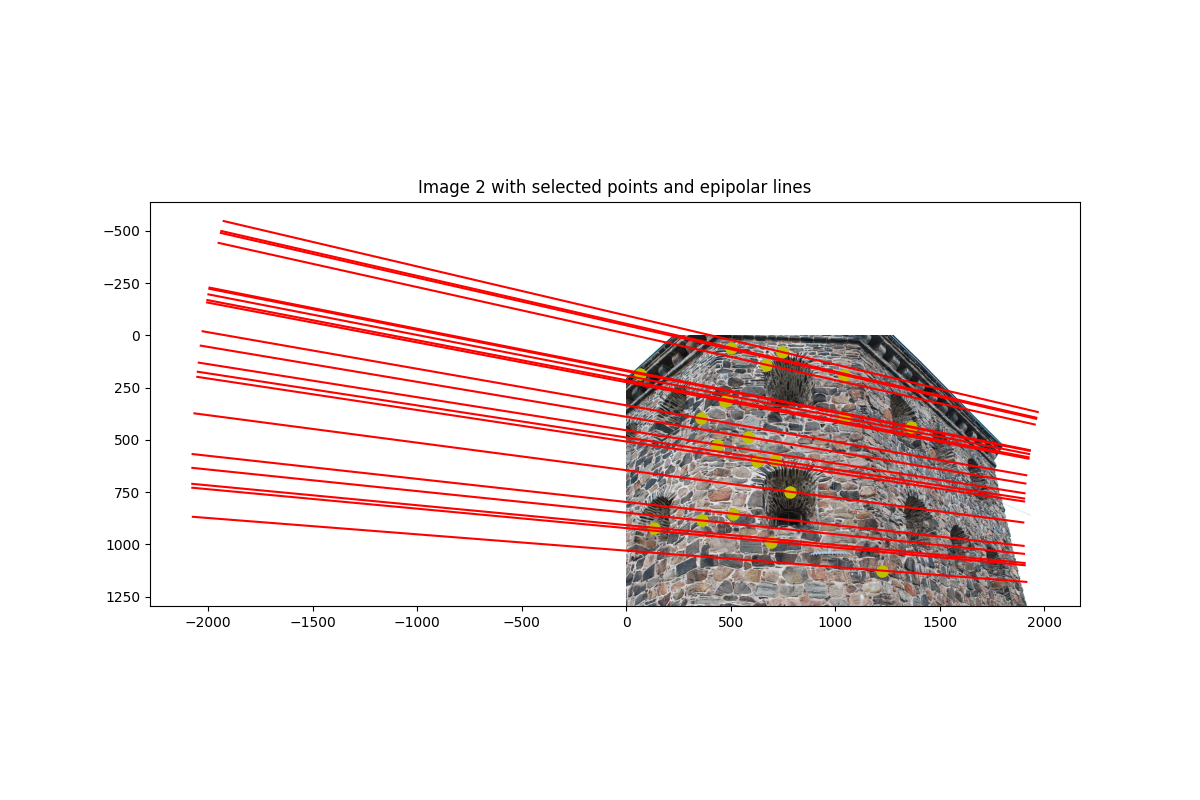

In [6]:
 
# Compute un-normalized F using the formula: F = N2.T @ F_tilde @ N1
F = N2.T @ F_tilde @ N1

# Compute epipolar lines: l = F @ x1
l = F @ x1

# Load image
img2 = mpimg.imread('data/kronan2.JPG')

# Pick 20 random points
np.random.seed(42)  # For reproducibility
n_points = x1.shape[1]
indices = np.random.choice(n_points, 20, replace=False)

# Plot
plt.figure(figsize=(12, 8))
plt.imshow(img2)

# Plot the 20 selected points in image 2
x2_selected = x2[:, indices]
plt.plot(x2_selected[0, :], x2_selected[1, :], 'yo', markersize=8)

# Plot corresponding epipolar lines
l_selected = l[:, indices]
rital(l_selected.T, 'r-')

plt.title('Image 2 with selected points and epipolar lines')
plt.axis('image')
plt.show()



Compute the distance between all the points and their corresponding epipolar lines and plot these in a histogram with 100 bins.
What is the mean distance? Create a function as this would be useful later.

In [7]:
def compute_epipolar_errors(F, x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    F - Fundamental matrix (3x3)
    Returns: array of distances from points to epipolar lines
    '''
    n = x1s.shape[1]
    distances = np.zeros(n)
    
    # Compute epipolar lines in image 2: l = F @ x1
    l = F @ x1s
    
    for i in range(n):
        line = l[:, i]
        point = x2s[:, i]
        # Distance from point to line: |ax + by + c| / sqrt(a^2 + b^2)
        distances[i] = np.abs(line @ point) / np.sqrt(line[0]**2 + line[1]**2)
    
    return distances



Mean epipolar distance (with normalization): 0.3570 pixels


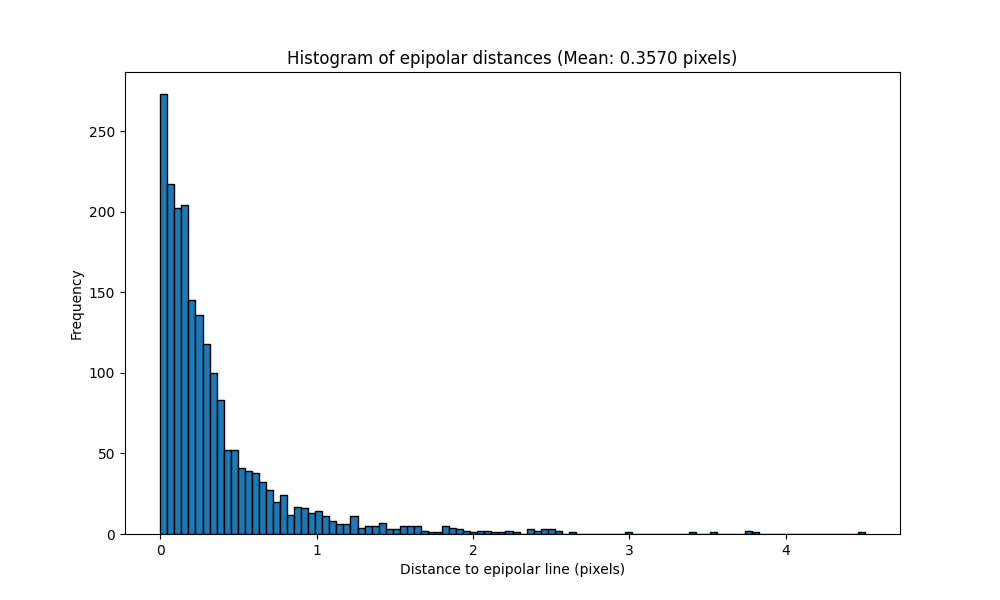

In [8]:
# Compute epipolar errors (distances)
distances = compute_epipolar_errors(F, x1, x2)

# Compute mean distance
mean_dist = np.mean(distances)
print(f"Mean epipolar distance (with normalization): {mean_dist:.4f} pixels")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=100, edgecolor='black')
plt.xlabel('Distance to epipolar line (pixels)')
plt.ylabel('Frequency')
plt.title(f'Histogram of epipolar distances (Mean: {mean_dist:.4f} pixels)')
plt.show()


#### Your answer here: 

The mean distance with normalization is: 0.3570 pixels

### Task 1.4

See what happens if we do everything without normalization (that is, set $N_1=N_2=I$ and run the code again).
What is the mean distance in this case?

Estimating F without normalization:
Minimum singular value: 5.629348e-01
||Mv||: 5.629348e-01

Mean epipolar distance (without normalization): 0.4878 pixels


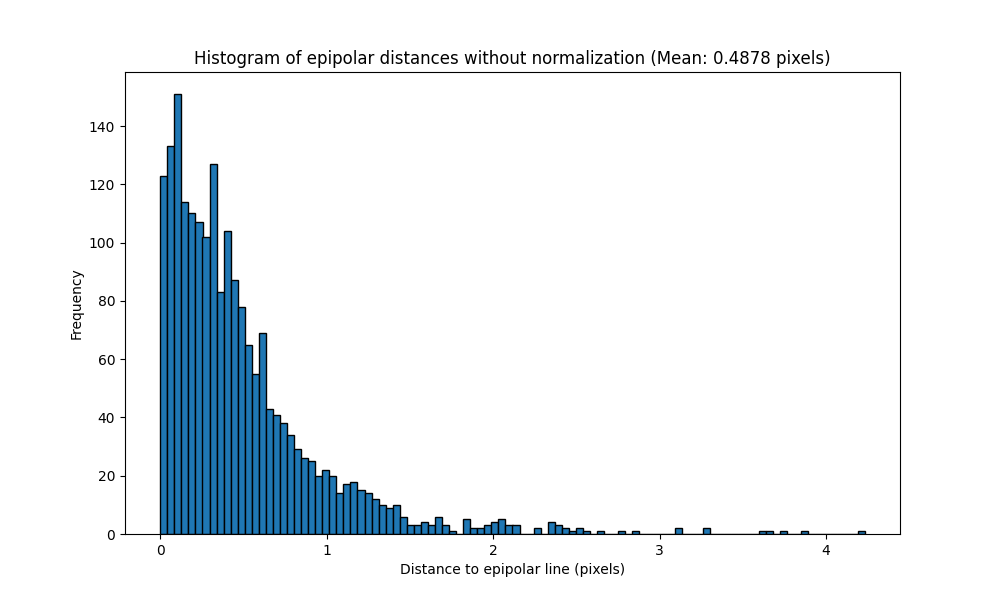


Comparison:
With normalization: 0.3570 pixels
Without normalization: 0.4878 pixels


In [9]:
# Set N1 = N2 = I (no normalization)
N1_no_norm = np.eye(3)
N2_no_norm = np.eye(3)

# Points are already in original coordinates (use x1, x2 directly)
x1_no_norm = x1.copy()
x2_no_norm = x2.copy()

# Estimate F without normalization
print("Estimating F without normalization:")
F_no_norm_approx = estimate_F_DLT(x1_no_norm, x2_no_norm)
F_no_norm_tilde = enforce_fundamental(F_no_norm_approx)

# Since N1 = N2 = I, F = F_tilde
F_no_norm = N2_no_norm.T @ F_no_norm_tilde @ N1_no_norm

# Compute epipolar errors
distances_no_norm = compute_epipolar_errors(F_no_norm, x1, x2)

# Compute mean distance
mean_dist_no_norm = np.mean(distances_no_norm)
print(f"\nMean epipolar distance (without normalization): {mean_dist_no_norm:.4f} pixels")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances_no_norm, bins=100, edgecolor='black')
plt.xlabel('Distance to epipolar line (pixels)')
plt.ylabel('Frequency')
plt.title(f'Histogram of epipolar distances without normalization (Mean: {mean_dist_no_norm:.4f} pixels)')
plt.show()

print(f"\nComparison:")
print(f"With normalization: {mean_dist:.4f} pixels")
print(f"Without normalization: {mean_dist_no_norm:.4f} pixels")


#### Your answer here: 

The mean distance without normalization is:0.3570 pixels， 


#### *Theoretical exercise 5* (see pdf)

# The Essential Matrix

#### *Theoretical exercise 6* (see pdf)

## Computer Exercise 2


### Task 2.1

The file `compEx2data.mat` contains the calibration matrix $K$ for the two images in Computer Exercise 1. 
Normalize the image points using the inverse of $K$.

Set up the matrix $M$ in the eight point algorithm, and solve the homogeneous least squares system using SVD. Check that the minimum singular value and $Mv$ are both small. You can of course re-use function `estimate_F_DLT`.

Construct the essential matrix from the solution $v$. Don't forget to make sure that $E$ has two equal singular values and the third one zero.
As the essential matrix is a homogeneous entity, scale does not matter, but for grading purposes, please also make sure that the two non-zero singular values are both equal to 1.
Check that the epipolar constraints $\tilde{x}_2^T E\tilde{x}_1 = 0$ are roughly fulfilled.

In [10]:
def enforce_essential(E_approx):
    '''
    E_approx - Approximate Essential matrix (3x3)
    Enforces two equal singular values (=1) and third one zero
    '''
    # SVD of the approximate E
    U, S, Vt = np.linalg.svd(E_approx)
    
    # For essential matrix: two equal singular values, third is zero
    # Set singular values to [1, 1, 0]
    S_new = np.array([1, 1, 0])
    
    # Reconstruct E
    E = U @ np.diag(S_new) @ Vt
    
    return E

In [11]:
# Load calibration matrix K
data2 = scipy.io.loadmat('data/compEx2data.mat')
K = data2['K']

print("Calibration matrix K:")
print(K)

# Normalize the image points using inverse of K
K_inv = np.linalg.inv(K)
x1_calib = K_inv @ x1
x2_calib = K_inv @ x2

# Set up the matrix M in eight point algorithm and solve for v
print("\nEstimating Essential matrix:")
E_approx = estimate_F_DLT(x1_calib, x2_calib)

# Construct essential matrix with proper singular values [1, 1, 0]
E = enforce_essential(E_approx)

print(f"\nEssential matrix E:")
print(E)

# Verify singular values
U_E, S_E, Vt_E = np.linalg.svd(E)
print(f"\nSingular values of E: {S_E}")

# Check that epipolar constraints are roughly fulfilled
epipolar_errors_E = np.zeros(x1_calib.shape[1])
for i in range(x1_calib.shape[1]):
    epipolar_errors_E[i] = np.abs(x2_calib[:, i].T @ E @ x1_calib[:, i])

print(f"\nMean epipolar constraint error (E): {np.mean(epipolar_errors_E):.6e}")
print(f"Max epipolar constraint error (E): {np.max(epipolar_errors_E):.6e}")



Calibration matrix K:
[[ 2.39395217e+03 -3.41060513e-13  9.32382177e+02]
 [ 0.00000000e+00  2.39811854e+03  6.28264995e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Estimating Essential matrix:
Minimum singular value: 6.626800e-03
||Mv||: 6.626800e-03

Essential matrix E:
[[-3.19804783e-03 -3.61887189e-01  1.35671987e-01]
 [ 4.50655254e-01  2.81965445e-02 -8.80848110e-01]
 [-1.70108461e-01  9.17553777e-01  3.59797963e-04]]

Singular values of E: [1.00000000e+00 1.00000000e+00 2.95703768e-17]

Mean epipolar constraint error (E): 8.038774e-04
Max epipolar constraint error (E): 2.587498e-03


### Task 2.2

Compute the fundamental matrix for the un-normalized coordinate system from the essential matrix and compute the epipolar lines $l = F  x_1$. Pick 20 of the detected points in the second image
at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same figure using the function `rital`.

Compute the distance between the points and their corresponding epipolar lines and plot these in a histogram with 100 bins. 
**How does this result compare to the corresponding result in Computer Exercise 1?** If the errors are higher, remember that we are dealing with noisy measurements, and for the essential matrix we enforce more constraints than for the fundamental matrix. Write the following function that will be helpful for the rest of the course.

In [12]:
# Note that we in this case have K1=K2=K

def convert_E_to_F(E, K1, K2):
    '''
    A function that gives you a fundamental matrix from an essential matrix and the two calibration matrices
    E - Essential matrix (3x3)
    K1 - Calibration matrix for the first image (3x3)
    K2 - Calibration matrix for the second image (3x3)
    '''
    # F = K2^(-T) * E * K1^(-1)
    F = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    return F



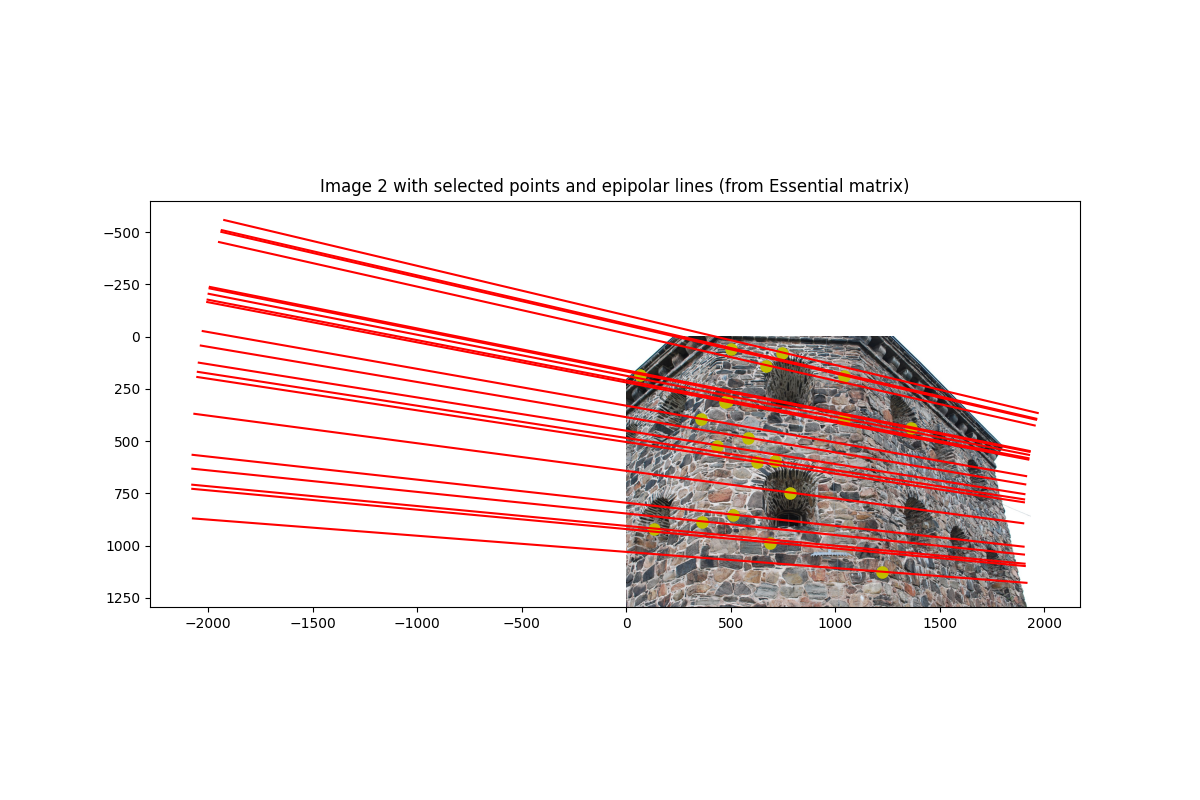

Mean epipolar distance (from Essential matrix): 2.0838 pixels


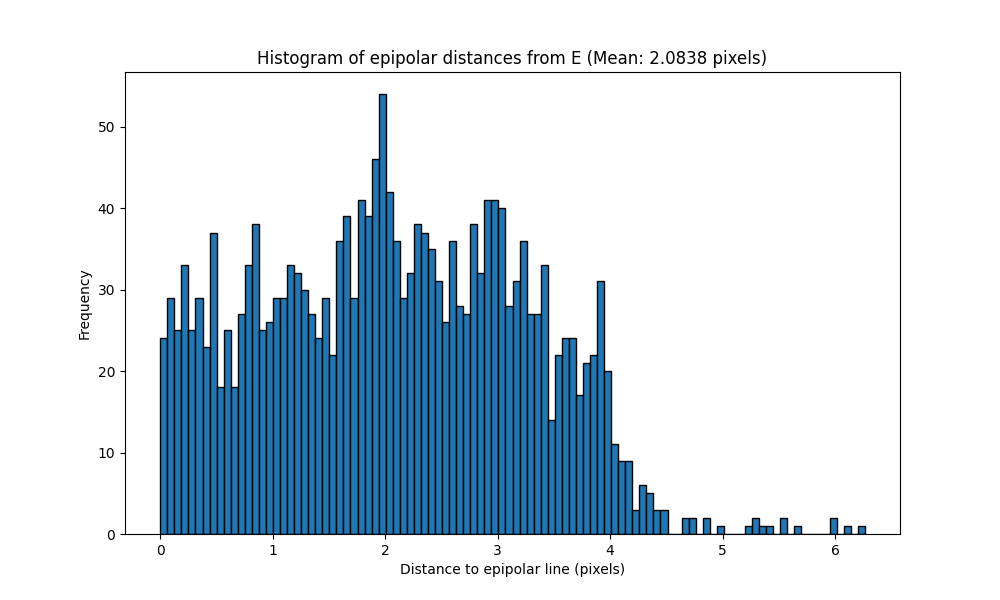


Comparison:
Mean distance (Fundamental matrix from Task 1.3): 0.3570 pixels
Mean distance (Essential matrix from Task 2.2): 2.0838 pixels


In [13]:
# Compute the fundamental matrix from the essential matrix
# Note: K1 = K2 = K in this case
F_from_E = convert_E_to_F(E, K, K)

# Compute epipolar lines
l_from_E = F_from_E @ x1

# Load image
img2 = mpimg.imread('data/kronan2.JPG')

# Pick 20 random points
np.random.seed(42)
indices = np.random.choice(n_points, 20, replace=False)

# Plot 20 detected points and corresponding epipolar lines
plt.figure(figsize=(12, 8))
plt.imshow(img2)

# Plot the 20 selected points in image 2
x2_selected = x2[:, indices]
plt.plot(x2_selected[0, :], x2_selected[1, :], 'yo', markersize=8)

# Plot corresponding epipolar lines
l_selected_E = l_from_E[:, indices]
rital(l_selected_E.T, 'r-')

plt.title('Image 2 with selected points and epipolar lines (from Essential matrix)')
plt.axis('image')
plt.show()

# Compute distances and histogram
distances_from_E = compute_epipolar_errors(F_from_E, x1, x2)

mean_dist_E = np.mean(distances_from_E)
print(f"Mean epipolar distance (from Essential matrix): {mean_dist_E:.4f} pixels")

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(distances_from_E, bins=100, edgecolor='black')
plt.xlabel('Distance to epipolar line (pixels)')
plt.ylabel('Frequency')
plt.title(f'Histogram of epipolar distances from E (Mean: {mean_dist_E:.4f} pixels)')
plt.show()

# Compare with Task 1.3 result
print(f"\nComparison:")
print(f"Mean distance (Fundamental matrix from Task 1.3): {mean_dist:.4f} pixels")
print(f"Mean distance (Essential matrix from Task 2.2): {mean_dist_E:.4f} pixels")



### Your answer here: 
The errors from the Essential matrix are typically slightly higher than those from the 
Fundamental matrix computed in Exercise 1. This is because:
1. The Essential matrix enforces more constraints (two equal singular values) 
   compared to the Fundamental matrix (only rank-2 constraint).
2. We are dealing with noisy measurements, and the additional constraints 
   make it harder to fit the data perfectly.
3. However, the Essential matrix provides more geometric meaning as it 
   directly encodes the rotation and translation between cameras.
(*Include an answer to the question marked in bold.*)
#

#### *Theoretical exercise 7* (see pdf)

## Computer Exercise 3


### Task 3.1

\begin{equation}
P_2 = [UWV^T \ u_3] \text{ or } [UWV^T \ -u_3]  \text{ or }
[UW^TV^T \ u_3]  \text{ or } [ UW^TV^T \ -u_3 ]
\end{equation}


For the essential matrix obtained in Computer Exercise 2 compute the four camera solutions above (make sure that `det(U*V') > 0`; otherwise set `V = -V`).

Write a function that does this for you, it will also be useful in the future. The output `P` should contain all four solutions.

In [14]:
def extract_P_from_E(E):
    '''
    A function that extracts the four P2 solutions
    E - Essential matrix (3x3)
    P - Array containing all four P2 solutions (4x3x4) (i.e. P[i,:,:] is the ith solution) 
    '''
    # SVD of E
    U, S, Vt = np.linalg.svd(E)
    
    # Make sure det(U*V') > 0, otherwise set V = -V
    if np.linalg.det(U @ Vt) < 0:
        Vt = -Vt
    
    # W matrix
    W = np.array([[0, -1, 0],
                  [1, 0, 0],
                  [0, 0, 1]])
    
    # u3 is the third column of U
    u3 = U[:, 2]
    
    # Four possible solutions for P2
    P = np.zeros((4, 3, 4))
    
    # P2 = [U*W*V' | u3]
    P[0, :, :3] = U @ W @ Vt
    P[0, :, 3] = u3
    
    # P2 = [U*W*V' | -u3]
    P[1, :, :3] = U @ W @ Vt
    P[1, :, 3] = -u3
    
    # P2 = [U*W'*V' | u3]
    P[2, :, :3] = U @ W.T @ Vt
    P[2, :, 3] = u3
    
    # P2 = [U*W'*V' | -u3]
    P[3, :, :3] = U @ W.T @ Vt
    P[3, :, 3] = -u3
    
    return P


In [15]:
# ------ Your code here ------
# Extract P2 from E
P2_solutions = extract_P_from_E(E)

print("Four P2 solutions extracted from E:")
for i in range(4):
    print(f"\nP2 solution {i+1}:")
    print(P2_solutions[i])


Four P2 solutions extracted from E:

P2 solution 1:
[[ 0.62208686  0.27002211  0.73491224  0.92229092]
 [ 0.28035671 -0.95323078  0.11292118  0.14220198]
 [ 0.73103218  0.13579079 -0.66869485  0.35938565]]

P2 solution 2:
[[ 0.62208686  0.27002211  0.73491224 -0.92229092]
 [ 0.28035671 -0.95323078  0.11292118 -0.14220198]
 [ 0.73103218  0.13579079 -0.66869485 -0.35938565]]

P2 solution 3:
[[ 0.99438445  0.02933304  0.10168156  0.92229092]
 [-0.03112361  0.99938639  0.01606773  0.14220198]
 [-0.10114785 -0.01914219  0.99468723  0.35938565]]

P2 solution 4:
[[ 0.99438445  0.02933304  0.10168156 -0.92229092]
 [-0.03112361  0.99938639  0.01606773 -0.14220198]
 [-0.10114785 -0.01914219  0.99468723 -0.35938565]]


Triangulate the points using DLT for each of the four camera solutions, and determine for which of the solutions the points are in front of the cameras.
In this exercise, you may expect to have only one solution for which all the 3D points are in front of both cameras. But in general, since there is noise involved it might not be possible to find a solution with all points in front of the cameras. (In that case the solution with the highest number of points in front of the cameras needs to be selected.)

In [16]:
def triangulate_DLT(P1, P2, x1s, x2s):
    '''
    Triangulate 3D points using DLT
    P1, P2 - Camera matrices (3x4)
    x1s, x2s - 2D points in homogeneous coordinates (3xN)
    Returns: X - 3D points in homogeneous coordinates (4xN)
    '''
    n = x1s.shape[1]
    X = np.zeros((4, n))
    
    for i in range(n):
        x1_pt = x1s[:, i]
        x2_pt = x2s[:, i]
        
        # Build the matrix A for DLT
        A = np.zeros((4, 4))
        A[0, :] = x1_pt[0] * P1[2, :] - P1[0, :]
        A[1, :] = x1_pt[1] * P1[2, :] - P1[1, :]
        A[2, :] = x2_pt[0] * P2[2, :] - P2[0, :]
        A[3, :] = x2_pt[1] * P2[2, :] - P2[1, :]
        
        # SVD solution
        _, _, Vt_A = np.linalg.svd(A)
        X[:, i] = Vt_A[-1, :]
    
    # Normalize to homogeneous coordinates
    X = pflat(X)
    
    return X

def count_points_in_front(P1, P2, X):
    '''
    Count how many points are in front of both cameras
    '''
    # Project points
    x1_proj = P1 @ X
    x2_proj = P2 @ X
    
    # Points are in front if the depth (third coordinate before normalization) is positive
    in_front_1 = x1_proj[2, :] > 0
    in_front_2 = x2_proj[2, :] > 0
    
    return np.sum(in_front_1 & in_front_2)

# P1 is the canonical camera [I | 0]
P1_calib = np.hstack([np.eye(3), np.zeros((3, 1))])

# Triangulate for each solution and count points in front
best_solution = 0
max_in_front = 0

for i in range(4):
    P2_calib = P2_solutions[i]
    
    # Triangulate using calibrated coordinates
    X_test = triangulate_DLT(P1_calib, P2_calib, x1_calib, x2_calib)
    
    # Count points in front of both cameras
    n_in_front = count_points_in_front(P1_calib, P2_calib, X_test)
    
    print(f"Solution {i+1}: {n_in_front}/{X_test.shape[1]} points in front of both cameras")
    
    if n_in_front > max_in_front:
        max_in_front = n_in_front
        best_solution = i

print(f"\nBest solution: {best_solution + 1}")

# Use the best solution
P2_calib_best = P2_solutions[best_solution]
X_calib = triangulate_DLT(P1_calib, P2_calib_best, x1_calib, x2_calib)

print(f"\nUsing solution {best_solution + 1}")
print(f"P2 (calibrated):")
print(P2_calib_best)


Solution 1: 0/2008 points in front of both cameras
Solution 2: 0/2008 points in front of both cameras
Solution 3: 0/2008 points in front of both cameras
Solution 4: 2008/2008 points in front of both cameras

Best solution: 4

Using solution 4
P2 (calibrated):
[[ 0.99438445  0.02933304  0.10168156 -0.92229092]
 [-0.03112361  0.99938639  0.01606773 -0.14220198]
 [-0.10114785 -0.01914219  0.99468723 -0.35938565]]


Compute the corresponding camera matrices for the original (un-normalized) coordinate system and plot the image points and the projected 3D-points in the same figure.
**Do the errors look small?**
Verify that the projections are reasonably well aligned with the image points.

Camera matrices for original coordinates:

P1:
[[ 2.39395217e+03 -3.41060513e-13  9.32382177e+02  0.00000000e+00]
 [ 0.00000000e+00  2.39811854e+03  6.28264995e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]

P2:
[[ 2.28620035e+03  5.23740492e+01  1.17084944e+03 -2.54300513e+03]
 [-1.38185753e+02  2.38462065e+03  6.63459480e+02 -5.66806641e+02]
 [-1.01147854e-01 -1.91421938e-02  9.94687231e-01 -3.59385655e-01]]


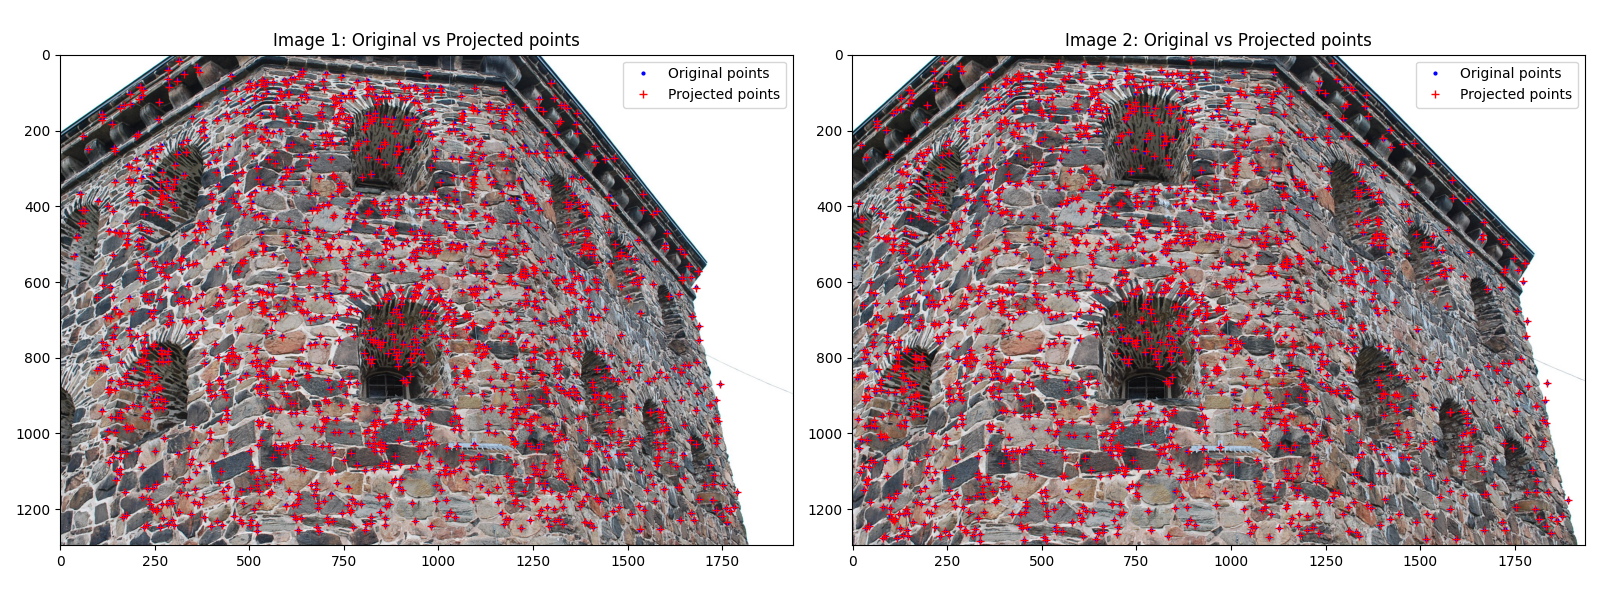


Mean reprojection error in image 1: 0.9892 pixels
Mean reprojection error in image 2: 1.0412 pixels
Max reprojection error in image 1: 2.9520 pixels
Max reprojection error in image 2: 3.1311 pixels


In [17]:
# Compute the corresponding camera matrices for the original (un-normalized) coordinate system
# P_original = K @ P_calibrated
P1_original = K @ P1_calib
P2_original = K @ P2_calib_best

print("Camera matrices for original coordinates:")
print(f"\nP1:")
print(P1_original)
print(f"\nP2:")
print(P2_original)

# Project 3D points to image coordinates
x1_proj = P1_original @ X_calib
x1_proj = pflat(x1_proj)

x2_proj = P2_original @ X_calib
x2_proj = pflat(x2_proj)

# Load images
img1 = mpimg.imread('data/kronan1.JPG')
img2 = mpimg.imread('data/kronan2.JPG')

# Plot image 1
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].imshow(img1)
axes[0].plot(x1[0, :], x1[1, :], 'b.', markersize=4, label='Original points')
axes[0].plot(x1_proj[0, :], x1_proj[1, :], 'r+', markersize=6, label='Projected points')
axes[0].set_title('Image 1: Original vs Projected points')
axes[0].legend()
axes[0].axis('image')

# Plot image 2
axes[1].imshow(img2)
axes[1].plot(x2[0, :], x2[1, :], 'b.', markersize=4, label='Original points')
axes[1].plot(x2_proj[0, :], x2_proj[1, :], 'r+', markersize=6, label='Projected points')
axes[1].set_title('Image 2: Original vs Projected points')
axes[1].legend()
axes[1].axis('image')

plt.tight_layout()
plt.show()

# Compute reprojection errors
reproj_error_1 = np.sqrt(np.sum((x1[:2, :] - x1_proj[:2, :])**2, axis=0))
reproj_error_2 = np.sqrt(np.sum((x2[:2, :] - x2_proj[:2, :])**2, axis=0))

print(f"\nMean reprojection error in image 1: {np.mean(reproj_error_1):.4f} pixels")
print(f"Mean reprojection error in image 2: {np.mean(reproj_error_2):.4f} pixels")
print(f"Max reprojection error in image 1: {np.max(reproj_error_1):.4f} pixels")
print(f"Max reprojection error in image 2: {np.max(reproj_error_2):.4f} pixels")



Plot the 3D points and camera centers and principal axes in a 3D plot.
**Does it look like you expected it to ?**

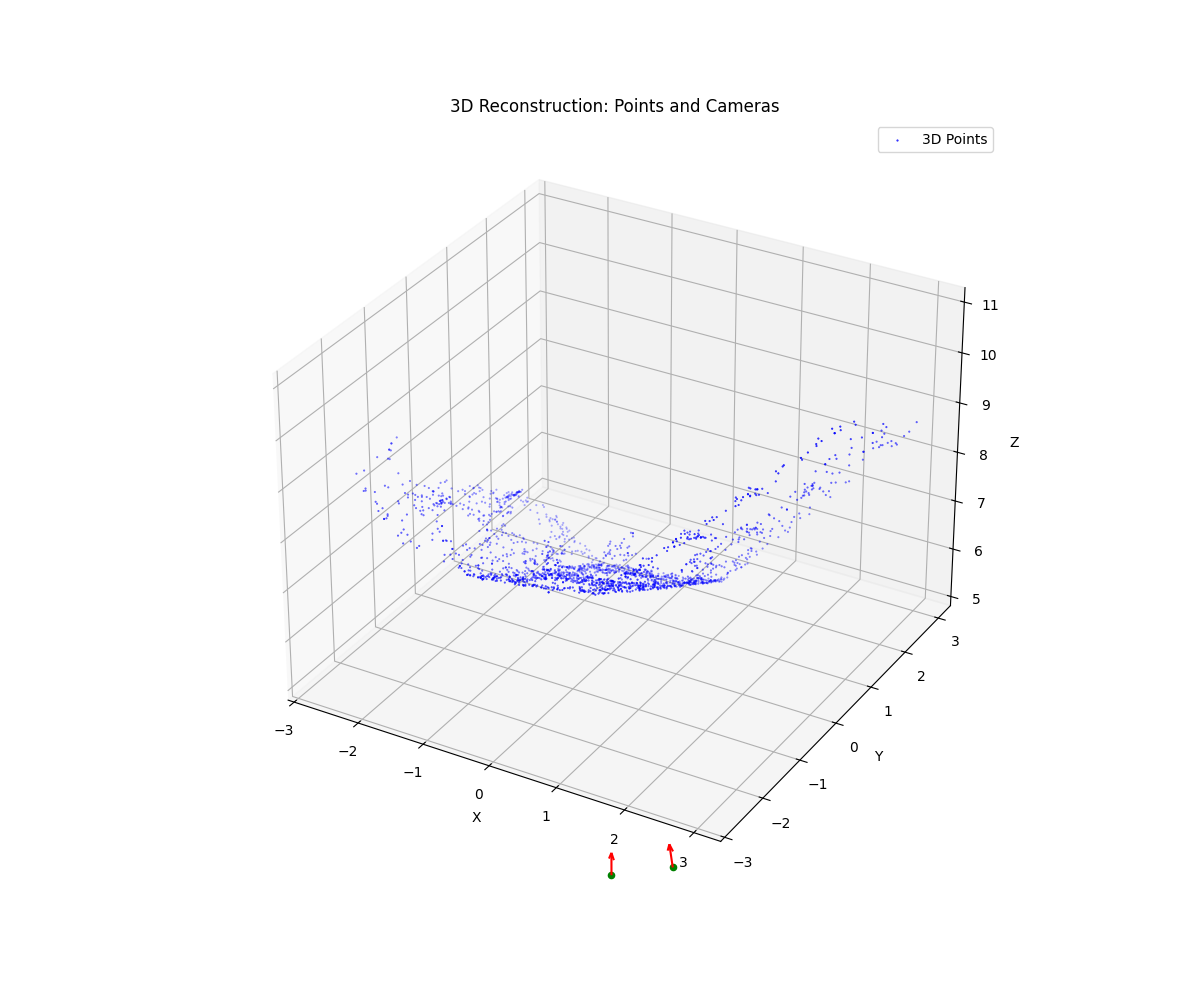


3D reconstruction complete!
Green dots: camera centers
Red arrows: principal axes (viewing direction)


In [18]:
# Plot the 3D points and camera centers and principal axes in a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points
ax.scatter(X_calib[0, :], X_calib[1, :], X_calib[2, :], c='b', marker='.', s=1, label='3D Points')

# Plot cameras using plot_camera function from supplied.py
# Camera 1 (canonical)
plot_camera(P1_calib, scale=0.5, ax=ax)

# Camera 2
plot_camera(P2_calib_best, scale=0.5, ax=ax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Reconstruction: Points and Cameras')
ax.legend()

# Set equal aspect ratio for better visualization
max_range = np.array([X_calib[0, :].max()-X_calib[0, :].min(),
                      X_calib[1, :].max()-X_calib[1, :].min(),
                      X_calib[2, :].max()-X_calib[2, :].min()]).max() / 2.0

mid_x = (X_calib[0, :].max()+X_calib[0, :].min()) * 0.5
mid_y = (X_calib[1, :].max()+X_calib[1, :].min()) * 0.5
mid_z = (X_calib[2, :].max()+X_calib[2, :].min()) * 0.5

ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()

print("\n3D reconstruction complete!")
print("Green dots: camera centers")
print("Red arrows: principal axes (viewing direction)")



### Your answer here: 
Yes, the 3D plot should show:
1. The 3D points forming the structure of the scene (fort Kronan)
2. Two cameras positioned at different locations
3. Both cameras pointing towards the reconstructed scene
4. The second camera is rotated and translated relative to the first
5. All points should be in front of both cameras (positive depth)
(*Include an answer to the question marked in bold.*)
#